# Network Training

In this tutorial, we introduce different topics related to the training of deep neural networks, including data augmentation, optimization/regularization techniques, weight initializations and hyperparameters tuning.


In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Preliminary

We load the MNIST dataset and define a model for digit classification using our function `get_data_model`, which returns a fresh untrained model along with PyTorch data loaders for training and testing. The `train` function performs the training loop with a given loss function and optimizer, recording the training and validation losses across epochs. Finally, `plot_history` visualizes these losses to track convergence and compare different experiments.

In [2]:
def get_data_model(train_transform=None, test_transform=None):
    # Transform: flatten images to 784 vector and normalize to [0,1]
    if (train_transform is None):
      train_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda x: x.view(-1))
      ])
    if (test_transform is None):
      test_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda x: x.view(-1))
      ])

    # Load datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

    # Model definition
    class SimpleMLP(nn.Module):
        def __init__(self):
            super(SimpleMLP, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )
        def forward(self, x):
            return self.net(x)

    model = SimpleMLP()

    return model, train_loader, test_loader

model, train_loader, test_loader = get_data_model()
print(model)

100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.22MB/s]

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [3]:
def train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            # Compute predictions and accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        if val_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_running_loss += loss.item() * inputs.size(0)

                    preds = torch.argmax(outputs, dim=1)
                    val_correct += (preds == targets).sum().item()
                    val_total += targets.size(0)

            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}"
              + (f" - Val loss: {val_loss:.4f}, acc: {val_acc:.4f}" if val_loader else ""))

    history = {
        'loss': train_losses,
        'accuracy': train_accs,
    }
    if val_loader:
        history['val_loss'] = val_losses
        history['val_accuracy'] = val_accs

    return history



In [81]:
def plot_history(history, metric=None):
    if metric is not None and metric in history:
        plt.figure(figsize=(8, 5))
        fig, axes = plt.subplots(2, 1)

        # Top plot: Accuracy
        axes[0].plot(history[metric])
        if 'val_' + metric in history:
            axes[0].plot(history['val_' + metric])
            axes[0].legend(['Train', 'Val'])
        axes[0].set_title('Model ' + metric.capitalize())
        axes[0].set_ylabel(metric.capitalize())
        axes[0].set_xlabel('Epoch')
        axes[0].grid(True)

        fig.subplots_adjust(hspace=0.5)

        # Bottom plot: Loss
        axes[1].plot(history['loss'])
        if 'val_loss' in history:
            axes[1].plot(history['val_loss'])
            axes[1].legend(['Train', 'Val'])
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].grid(True)
    else:
        plt.figure(figsize=(8, 2))
        plt.plot(history['loss'])
        if 'val_loss' in history:
            plt.plot(history['val_loss'])
            plt.legend(['Train', 'Val'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.show()

## Optimizers

In a deep learning problem, the weights of a network are updated to minimize the loss in each optimization step. Optimizers define the specific method used to update in each timestep the weights of the network. For example, the vanilla Stochastic Gradient Descent (SGD) only uses the gradient of the weight with respect to the loss in the current timestep $t$, along with the learning rate, to update the weights. However, other optimizers use more sophisticate methods (e.g., keeping track of past gradient updates to use as momentum) to compute the weights' updates.

Since there are optimizers more prone to get stuck in local minima, the choice of the optimizer can potentially affect both the final performance and the speed of convergence.  A nice visualization of such behavior is the following animation, where you can notice some methods, i.e., Adadelta (yellow), and Rmsprop (black) converge significantly faster than SGD (red), which gets stuck in a local minimum.

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

The animation above is from [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/), who wrote an interesting article showing the formulation and properties of the different optimizers. We are not going to analyze the properties of the different optimizers, but you can read the blog post if you are interested in how optimizers work. As a rule of thumb, Adam is usually easier to tune due to the adaptive learning rate, whereas SGD with momentum [has been shown](https://arxiv.org/pdf/1712.07628.pdf) to reach better results when tuned correctly.

In this tutorial, we will follow a hands-on approach and focus mainly on how to use [optimizers in PyTorch](https://pytorch.org/docs/stable/optim.html). PyTorch requires you to create an optimizer object explicitly by passing it the model parameters and any desired hyperparameters, such as the learning rate. For example, the following code creates an Adam optimizer with default parameters:

Epoch 1/10 - Train loss: 0.2518, acc: 0.9260 - Val loss: 0.1343, acc: 0.9558
Epoch 2/10 - Train loss: 0.0915, acc: 0.9725 - Val loss: 0.0734, acc: 0.9775
Epoch 3/10 - Train loss: 0.0597, acc: 0.9812 - Val loss: 0.0707, acc: 0.9776
Epoch 4/10 - Train loss: 0.0414, acc: 0.9866 - Val loss: 0.0855, acc: 0.9736
Epoch 5/10 - Train loss: 0.0330, acc: 0.9896 - Val loss: 0.0849, acc: 0.9764
Epoch 6/10 - Train loss: 0.0262, acc: 0.9914 - Val loss: 0.0864, acc: 0.9760
Epoch 7/10 - Train loss: 0.0215, acc: 0.9930 - Val loss: 0.0707, acc: 0.9805
Epoch 8/10 - Train loss: 0.0191, acc: 0.9934 - Val loss: 0.0858, acc: 0.9774
Epoch 9/10 - Train loss: 0.0152, acc: 0.9948 - Val loss: 0.0911, acc: 0.9781
Epoch 10/10 - Train loss: 0.0155, acc: 0.9949 - Val loss: 0.0759, acc: 0.9816


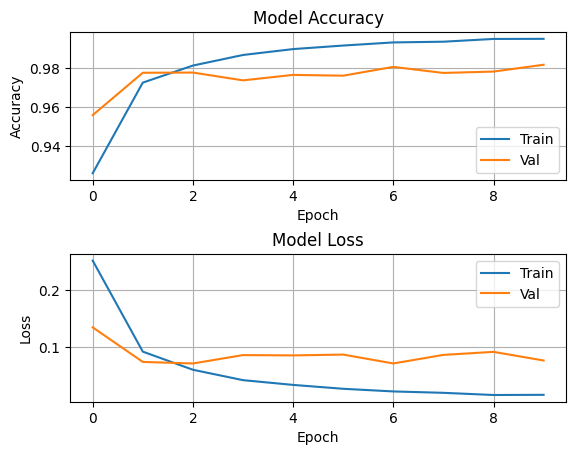

In [5]:
model, train_loader, test_loader = get_data_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) # default lr = 1e-3
history = train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=test_loader)
plot_history(history, "accuracy")

However, it is common to adjust optimizer parameters such as the learning rate, which controls how quickly the weights are updated during training. In PyTorch, you do this when you create the optimizer by specifying the desired settings. For example, the following code uses Adam with a custom learning rate of 0.0003:

Epoch 1/10 - Train loss: 0.3841, acc: 0.8973 - Val loss: 0.1754, acc: 0.9494
Epoch 2/10 - Train loss: 0.1466, acc: 0.9570 - Val loss: 0.1204, acc: 0.9642
Epoch 3/10 - Train loss: 0.0968, acc: 0.9718 - Val loss: 0.1009, acc: 0.9693
Epoch 4/10 - Train loss: 0.0702, acc: 0.9789 - Val loss: 0.0828, acc: 0.9727
Epoch 5/10 - Train loss: 0.0530, acc: 0.9842 - Val loss: 0.0817, acc: 0.9739
Epoch 6/10 - Train loss: 0.0412, acc: 0.9870 - Val loss: 0.0661, acc: 0.9788
Epoch 7/10 - Train loss: 0.0307, acc: 0.9908 - Val loss: 0.0615, acc: 0.9797
Epoch 8/10 - Train loss: 0.0230, acc: 0.9935 - Val loss: 0.0650, acc: 0.9792
Epoch 9/10 - Train loss: 0.0194, acc: 0.9946 - Val loss: 0.0682, acc: 0.9796
Epoch 10/10 - Train loss: 0.0153, acc: 0.9957 - Val loss: 0.0681, acc: 0.9795


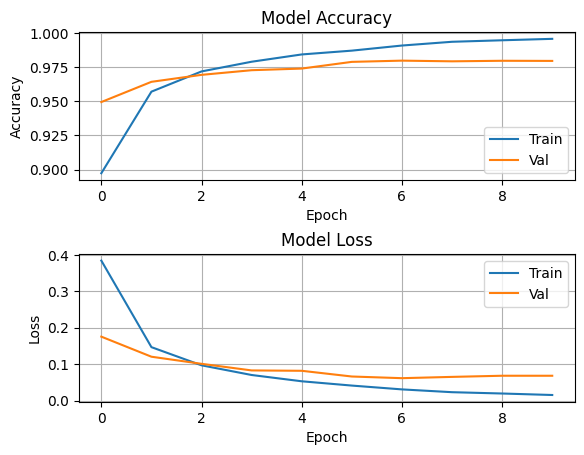

In [6]:
model, train_loader, test_loader = get_data_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
history = train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=test_loader)
plot_history(history, "accuracy")

## Initializers


Neural Networks have a large number of weights that need to be initialized properly. Weight initialization is a crucial step in tuning neural networks as different initial values can lead the model to reach different local minima. If your initial weights are too small, the network may have problems learning due to small/vanishing gradients. However, if they are too large, you may run into exploding gradients or you could saturate an activation in the network (e.g. a sigmoid). Hence, we need a proper initialization with not too large nor not too small weights. In [this link](https://www.deeplearning.ai/ai-notes/initialization/) you can find an explanation of the importance of weight initialization.  

The weights are usually initialized randomly by different algorithms, such as Xavier, He, or LeCun initialization, each designed to have specific properties under certain assumptions.

In Keras, you can set the particular initialization strategy you want to use as an argument when declaring a layer. The available initialization methods in Keras are listed [here](https://keras.io/api/layers/initializers/).  The initializers are passed to the layers via the arguments `kernel_initializer` and `bias_initializer`. For instance, in the function `Dense()`, which defines the mapping $y= Ax + b$, you can initialize the kernel values ($A$ in the equation) with a normal distribution (by default the `stddev` is 0.05) and the bias ($b$ in the equation) with $0$ using the code below.

In PyTorch, you set the initialization explicitly by calling functions from `torch.nn.init` on the model's parameters after you create the layers. The available initialization methods in PyTorch are listed in the documentation. For example, to initialize a `Linear` layer so that the weights (`A` in the equation $y=Ax+b$) are drawn from a normal distribution (with a given standard deviation) and the biases (`b`) are set to zero, you can use the code below:

In [7]:
layer = nn.Linear(in_features=784, out_features=512)

# Initialize weights with a normal distribution (mean=0, std=0.05)
nn.init.normal_(layer.weight, mean=0.0, std=0.05)

# Initialize biases to zero
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

Now let's check the weights of the layers and see if they follow the distributions we set.

In [8]:
# Access weights and biases
weight_tensor = layer.weight.detach().numpy()
bias_tensor = layer.bias.detach().numpy()

print(weight_tensor)

[[ 5.1495034e-02  7.5837672e-02  2.4775995e-02 ... -3.1257026e-02
  -2.1392832e-02  1.1929081e-01]
 [ 2.5231956e-02 -2.0784618e-02 -4.6945322e-02 ... -9.7453929e-03
  -6.6429503e-02 -4.8672162e-02]
 [-3.7850928e-03  4.8277274e-02 -3.8489723e-03 ... -3.4133475e-02
  -1.1946479e-02  1.1348670e-02]
 ...
 [-6.3252628e-02 -2.8821671e-02  6.2569864e-02 ... -4.1194504e-05
   5.2549120e-02 -4.9851552e-02]
 [ 2.3704378e-02 -3.0081482e-03  7.2238022e-03 ...  2.4997707e-02
   2.1766590e-02 -2.6666263e-02]
 [-1.1874630e-01  5.5793256e-02  1.6288616e-03 ...  2.1250095e-02
   5.0363507e-02  5.6915816e-02]]


In [9]:
# Now let's check that the mean is 0 and stddev is 0.05
print("Mean: {:.5f}\nStandard Deviation: {:.5f}".format(weight_tensor.mean(), weight_tensor.std()))

Mean: 0.00001
Standard Deviation: 0.04991


In [10]:
# Let's print the bias now
print(bias_tensor)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

By default, the kernel weights in PyTorch `nn.Linear` layers are initialized from a uniform distribution with bounds determined by the number of input units. Specifically, the weights are sampled uniformly from the range [-1 / √f_in, +1 / √f_in], where *f_in* is the number of input features. The bias is initialized uniformly in the same range. Another commonly used initializer is `kaiming_normal`, which draws weights from a normal distribution scaled for ReLU activations. In most cases, the default initialization in PyTorch works well and allows models to train properly without any changes.





## Loss

Another important step in training deep neural networks is the choice of the loss function, which depends on your specific problem. The full list of standard losses in PyTorch is available [here](https://pytorch.org/docs/stable/nn.html#loss-functions). Although in past tutorials we already used some losses, we now introduce two typical ones: cross-entropy and mean squared error, which are commonly used for classification and regression tasks, respectively.


### Classification

For classification problems, the standard loss used is the cross-entropy loss. For the binary case, the formula is $L = y\log(p) + (1-y)\log(1-p)$, where $p$ is a probability value between $[0, 1]$.
Typically, a [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) is applied in the binary case to constrain the output to be between 0 and 1.  

In PyTorch, this binary classification loss is implemented as `nn.BCELoss` if you apply the sigmoid activation yourself, or as `nn.BCEWithLogitsLoss`, which combines a sigmoid layer and the binary cross-entropy loss in a single function for numerical stability. This loss expects targets as a vector of values in $[0, 1]$ (usually either 0 or 1) for each input element.  

Below, we show an example of binary classification in PyTorch. To do so, we transform MNIST into a binary classification problem by classifying whether a digit is between 0–4 or 5–9.


In [11]:
# Change to single output neuron
model, train_loader, test_loader = get_data_model()
model.net[-1] = nn.Linear(512, 1)
print(model)

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [12]:
# Reload MNIST datasets with transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert targets to binary: 0 if digit < 5, 1 if >= 5
train_dataset.targets = (train_dataset.targets >= 5).long()
test_dataset.targets = (test_dataset.targets >= 5).long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_binary(model, train_loader, criterion, optimizer, num_epochs=3, val_loader=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.int() == targets).sum().item()
            total += targets.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        if val_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs).squeeze(1)
                    loss = criterion(outputs, targets.float())
                    val_running_loss += loss.item() * inputs.size(0)

                    preds = torch.sigmoid(outputs) > 0.5
                    val_correct += (preds.int() == targets).sum().item()
                    val_total += targets.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}"
              + (f" - Val loss: {val_loss:.4f}, acc: {val_acc:.4f}" if val_loader else ""))

    history = {
        'loss': train_losses,
        'accuracy': train_accs
    }
    if val_loader:
        history['val_loss'] = val_losses
        history['val_accuracy'] = val_accs
    return history


Epoch 1/3 - Train loss: 0.1123, acc: 0.9587 - Val loss: 0.0806, acc: 0.9724
Epoch 2/3 - Train loss: 0.0536, acc: 0.9812 - Val loss: 0.0627, acc: 0.9791
Epoch 3/3 - Train loss: 0.0389, acc: 0.9867 - Val loss: 0.0626, acc: 0.9810


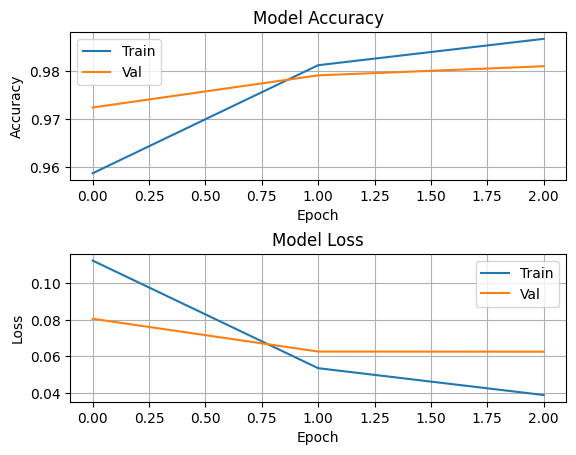

In [13]:
history = train_binary(model, train_loader, criterion, optimizer, num_epochs=3,
                       val_loader=test_loader)
plot_history(history, 'accuracy')

When the number of classes is higher than 2, we use the cross-entropy loss, which is $L = -\sum_i y_i\log(p_i)$.

n PyTorch, this loss is implemented as `nn.CrossEntropyLoss`. It expects the model outputs to be raw logits (unnormalized scores) and the targets to be integer class indices in the range
[0,𝐶), where 𝐶 is the number of classes. Unlike some other frameworks, you do not need to one-hot encode the labels manually, as the function handles this internally.

Let’s see an example using the MNIST data.

In [14]:
# Load MNIST with flattening transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Show first 5 labels
for i in range(5):
    label = train_dataset.targets[i].item()
    print(f"Label Value: {label}")

Label Value: 5
Label Value: 0
Label Value: 4
Label Value: 1
Label Value: 9


The input for the cross-entropy needs to be a probability distribution, meaning that the sum of the elements should be $\sum_i p_i = 1$. However, in PyTorch you do not need to apply the [Softmax activation](https://en.wikipedia.org/wiki/Softmax_function) manually, because `nn.CrossEntropyLoss` automatically applies the `LogSoftmax` function internally. This means you can pass the raw, unnormalized outputs (logits) of your model directly to the loss function and use the predefined training utilities without any extra steps.

Epoch 1/3 - Train loss: 0.2507, acc: 0.9259 - Val loss: 0.1104, acc: 0.9639
Epoch 2/3 - Train loss: 0.0904, acc: 0.9722 - Val loss: 0.0854, acc: 0.9739
Epoch 3/3 - Train loss: 0.0575, acc: 0.9814 - Val loss: 0.0761, acc: 0.9776


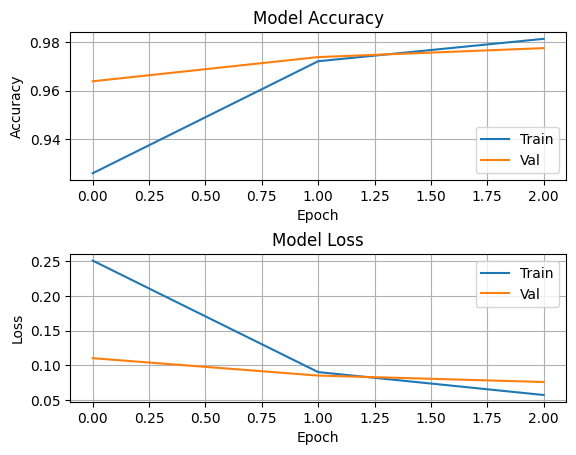

In [15]:
# Load model and data (MNIST)
model, train_loader, test_loader = get_data_model()

# Define the loss: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=3,
    val_loader=test_loader
)

plot_history(history, 'accuracy')

### Regression
In regression problems, it is common to use as losses the Mean Squared Error (MSE) or Mean Absolute Error (MAE). We now show a quick example using the California Housing dataset, which contains a set of input features and we aim to predict the price of the house.

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(y_train[:10])


[1.03    3.821   1.726   0.934   0.965   2.648   1.573   5.00001 1.398
 3.156  ]


We see that the labels are float numbers (the price of the house), and our goal is to predict those float numbers. To do so, we need a network that has only one output, so we define the `Regressor`.

In [17]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)


In [18]:
def train_regression(model, train_loader, criterion, optimizer, num_epochs=100, val_loader=None):
    train_mae = []
    val_mae = []
    train_mse = []
    val_mse = []

    mae_criterion = nn.L1Loss()
    mse_criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        running_mae = 0.0
        running_mse = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            mae_loss = mae_criterion(outputs, targets)
            mse_loss = mse_criterion(outputs, targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_mae += mae_loss.item() * inputs.size(0)
            running_mse += mse_loss.item() * inputs.size(0)

        epoch_mae = running_mae / len(train_loader.dataset)
        epoch_mse = running_mse / len(train_loader.dataset)
        train_mae.append(epoch_mae)
        train_mse.append(epoch_mse)

        if val_loader:
            model.eval()
            val_running_mae = 0.0
            val_running_mse = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    mae_loss = mae_criterion(outputs, targets)
                    mse_loss = mse_criterion(outputs, targets)
                    val_running_mae += mae_loss.item() * inputs.size(0)
                    val_running_mse += mse_loss.item() * inputs.size(0)
            val_mae_epoch = val_running_mae / len(val_loader.dataset)
            val_mse_epoch = val_running_mse / len(val_loader.dataset)
            val_mae.append(val_mae_epoch)
            val_mse.append(val_mse_epoch)

        print(
            f"Epoch {epoch+1}/{num_epochs} - "
            f"Train MAE: {epoch_mae:.4f}, MSE: {epoch_mse:.4f}"
            + (
                f" - Val MAE: {val_mae_epoch:.4f}, MSE: {val_mse_epoch:.4f}"
                if val_loader
                else ""
            )
        )

    history = {
        'mae': train_mae,
        'mse': train_mse,
    }
    if val_loader:
        history['val_mae'] = val_mae
        history['val_mse'] = val_mse
    return history


In [19]:
model_mae = Regressor()
criterion_mae = nn.L1Loss()
optimizer_mae = optim.Adam(model_mae.parameters(), lr=1e-3)

history_mae = train_regression(
    model_mae,
    train_loader,
    criterion_mae,
    optimizer_mae,
    num_epochs=100,
    val_loader=test_loader
)

Epoch 1/100 - Train MAE: 0.6804, MSE: 1.0212 - Val MAE: 0.4935, MSE: 0.5417
Epoch 2/100 - Train MAE: 0.4656, MSE: 0.4706 - Val MAE: 0.4564, MSE: 0.4722
Epoch 3/100 - Train MAE: 0.4418, MSE: 0.4272 - Val MAE: 0.4406, MSE: 0.4209
Epoch 4/100 - Train MAE: 0.4301, MSE: 0.4025 - Val MAE: 0.4358, MSE: 0.4114
Epoch 5/100 - Train MAE: 0.4225, MSE: 0.3905 - Val MAE: 0.4262, MSE: 0.3841
Epoch 6/100 - Train MAE: 0.4156, MSE: 0.3742 - Val MAE: 0.4215, MSE: 0.3964
Epoch 7/100 - Train MAE: 0.4107, MSE: 0.3713 - Val MAE: 0.4176, MSE: 0.3845
Epoch 8/100 - Train MAE: 0.4056, MSE: 0.3652 - Val MAE: 0.4079, MSE: 0.3703
Epoch 9/100 - Train MAE: 0.4009, MSE: 0.3552 - Val MAE: 0.4039, MSE: 0.3626
Epoch 10/100 - Train MAE: 0.3980, MSE: 0.3533 - Val MAE: 0.4000, MSE: 0.3510
Epoch 11/100 - Train MAE: 0.3941, MSE: 0.3453 - Val MAE: 0.3980, MSE: 0.3546
Epoch 12/100 - Train MAE: 0.3919, MSE: 0.3441 - Val MAE: 0.3997, MSE: 0.3660
Epoch 13/100 - Train MAE: 0.3893, MSE: 0.3438 - Val MAE: 0.3951, MSE: 0.3499
Epoch 14

Now we use the MSE loss:

In [20]:
model_mse = Regressor()
criterion_mse = nn.MSELoss()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-3)

history_mse = train_regression(
    model_mse,
    train_loader,
    criterion_mse,
    optimizer_mse,
    num_epochs=100,
    val_loader=test_loader
)

Epoch 1/100 - Train MAE: 0.6719, MSE: 0.9330 - Val MAE: 0.5040, MSE: 0.5023
Epoch 2/100 - Train MAE: 0.4770, MSE: 0.4531 - Val MAE: 0.4693, MSE: 0.4409
Epoch 3/100 - Train MAE: 0.4552, MSE: 0.4086 - Val MAE: 0.4617, MSE: 0.4094
Epoch 4/100 - Train MAE: 0.4481, MSE: 0.4051 - Val MAE: 0.4442, MSE: 0.3915
Epoch 5/100 - Train MAE: 0.4381, MSE: 0.3835 - Val MAE: 0.4375, MSE: 0.3797
Epoch 6/100 - Train MAE: 0.4299, MSE: 0.3682 - Val MAE: 0.4332, MSE: 0.3717
Epoch 7/100 - Train MAE: 0.4234, MSE: 0.3588 - Val MAE: 0.4285, MSE: 0.3663
Epoch 8/100 - Train MAE: 0.4200, MSE: 0.3566 - Val MAE: 0.4335, MSE: 0.3729
Epoch 9/100 - Train MAE: 0.4146, MSE: 0.3468 - Val MAE: 0.4117, MSE: 0.3509
Epoch 10/100 - Train MAE: 0.4098, MSE: 0.3408 - Val MAE: 0.4094, MSE: 0.3493
Epoch 11/100 - Train MAE: 0.4067, MSE: 0.3386 - Val MAE: 0.4104, MSE: 0.3502
Epoch 12/100 - Train MAE: 0.4036, MSE: 0.3354 - Val MAE: 0.4025, MSE: 0.3422
Epoch 13/100 - Train MAE: 0.4000, MSE: 0.3315 - Val MAE: 0.4021, MSE: 0.3385
Epoch 14

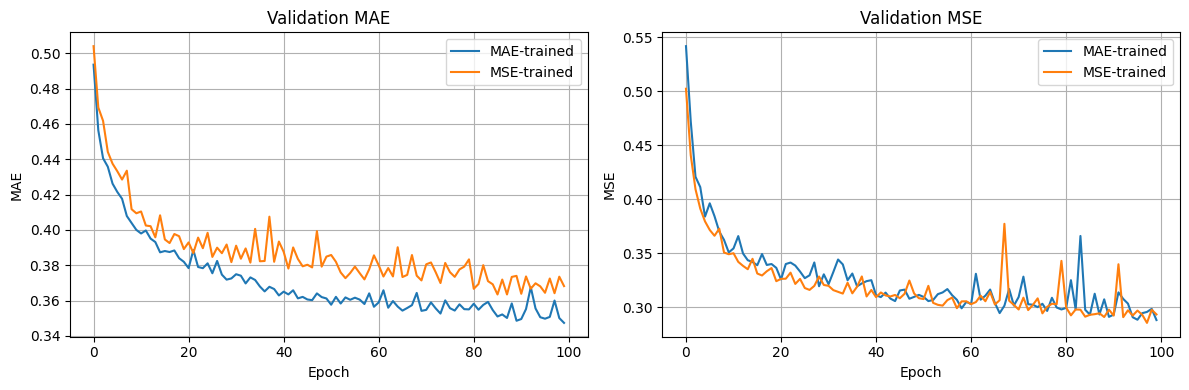

In [21]:
def plot_regression_comparison(history_mae, history_mse):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left: MAE metric comparison
    axes[0].plot(history_mae['val_mae'], label='MAE-trained')
    axes[0].plot(history_mse['val_mae'], label='MSE-trained')
    axes[0].set_title('Validation MAE')
    axes[0].set_ylabel('MAE')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # Right: MSE metric comparison
    axes[1].plot(history_mae['val_mse'], label='MAE-trained')
    axes[1].plot(history_mse['val_mse'], label='MSE-trained')
    axes[1].set_title('Validation MSE')
    axes[1].set_ylabel('MSE')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()
    plt.show()


plot_regression_comparison(history_mae=history_mae, history_mse=history_mse)

In [22]:
def evaluate_model(model, loader):
    model.eval()
    mae = nn.L1Loss()
    mse = nn.MSELoss()
    running_mae = 0.0
    running_mse = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            running_mae += mae(outputs, targets).item() * inputs.size(0)
            running_mse += mse(outputs, targets).item() * inputs.size(0)
    mae_final = running_mae / len(loader.dataset)
    mse_final = running_mse / len(loader.dataset)
    return mae_final, mse_final

mae_mae, mse_mae = evaluate_model(model_mae, test_loader)
print(f"MAE-trained model achieves MAE: {mae_mae:.4f} and MSE: {mse_mae:.4f}")

mae_mse, mse_mse = evaluate_model(model_mse, test_loader)
print(f"MSE-trained model achieves MAE: {mae_mse:.4f} and MSE: {mse_mse:.4f}")

MAE-trained model achieves MAE: 0.3474 and MSE: 0.2884
MSE-trained model achieves MAE: 0.3682 and MSE: 0.2936


The resulting plots show that training with MAE loss clearly achieves better MAE on the test set compared to training with MSE loss, which is expected. However, the difference in MSE between the two models is less pronounced and does not consistently favor the MSE-trained model. This can happen because MAE is more robust to outliers and can lead to solutions that also generalize well in terms of MSE, especially on relatively small datasets.

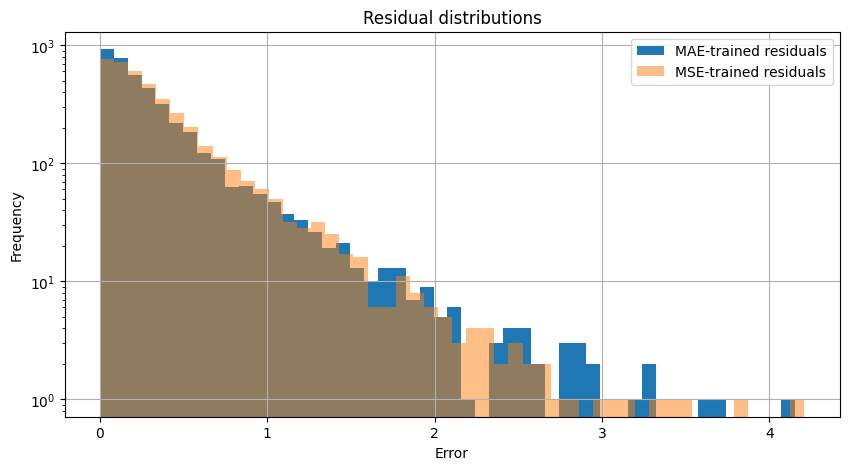

In [23]:
y_pred_mae = model_mae(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()
y_pred_mse = model_mse(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

residuals_mae = abs(y_test - y_pred_mae.flatten())
residuals_mse = abs(y_test - y_pred_mse.flatten())

plt.figure(figsize=(10,5))
plt.hist(residuals_mae, bins=50, alpha=1, label="MAE-trained residuals")
plt.hist(residuals_mse, bins=50, alpha=0.5, label="MSE-trained residuals")
plt.legend()
plt.title("Residual distributions")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid(True)
plt.show()


A problem usually treated as a regression problem with deep learning approaches is depth estimation, where the depth of an image is estimated using the RGB information. Some other regression losses are also used in some settings (e.g. Huber loss or Reverse Huber loss, or the already introduced Mean Percentage Absolute Error), but MAE and MSE are widely used.

## Regularization
As mentioned in the lecture, regularization is an effective tool to fight some of the problems we may have during training, such as vanishing/exploding gradients or overfitting to the training set. We now mention some of the usual ways to regularize our training process.

### Loss Regularizers

[Regularization](https://pytorch.org/docs/stable/nn.html#weight-norm) introduces penalties during optimization to discourage overly complex models. By penalizing large weight values, regularization helps constrain the model’s capacity and can reduce overfitting.

In PyTorch, regularization is usually applied in two main ways:

- **Weight decay**: adds an L2 penalty on the weights directly in the optimizer. This is the most common approach and is equivalent to L2 regularization.
- **Manual penalties**: you can compute additional penalties (e.g., L1 or custom norms) on weights or activations and add them to your loss function manually.

If we define the output of a layer as $y = Wx + b$, then:

- **Weight decay (L2 penalty)**: encourages smaller $W$ and $b$.
- **Custom penalties**: you can compute L1 or L2 norms of the parameters or activations and combine them with your loss.

Standard penalties commonly used are L1, L2, and combinations of both.

In the example below, we’ll see how to compare training and validation metrics by varying the regularization strategy (e.g., different values of weight decay).

In [24]:
# Load your existing get_data_model() function here
model, train_loader, test_loader = get_data_model()

# Function to train and return final training and test accuracy
def train_with_weight_decay(weight_decay, num_epochs=10):
    model, train_loader, test_loader = get_data_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate training accuracy
    model.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)
    train_acc = correct_train / total_train

    # Evaluate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)
    test_acc = correct_test / total_test

    return train_acc, test_acc

In [25]:
reg_values = [0.001, 0.0]
train_accuracy = []
test_accuracy = []

for reg_val in reg_values:
    print(f"Training with weight decay = {reg_val}")
    train_acc, test_acc = train_with_weight_decay(weight_decay=reg_val)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

Training with weight decay = 0.001
Training with weight decay = 0.0


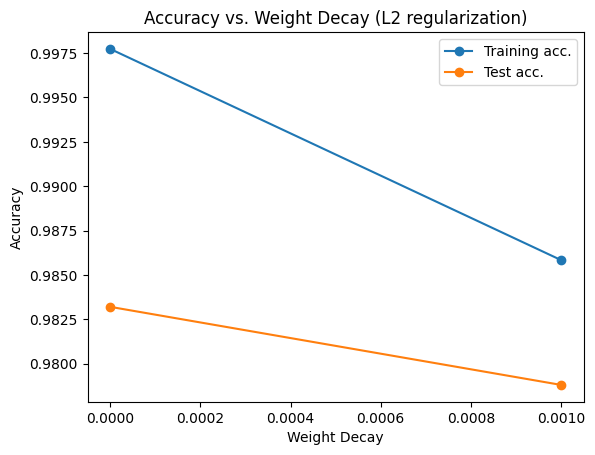

In [26]:
plt.figure()
plt.plot(reg_values, train_accuracy, marker='o')
plt.plot(reg_values, test_accuracy, marker='o')
plt.legend(['Training acc.', 'Test acc.'])
plt.title('Accuracy vs. Weight Decay (L2 regularization)')
plt.ylabel('Accuracy')
plt.xlabel('Weight Decay')
plt.show()

In this example, we show how a large regularization value dropped the final test accuracy, and also reduced the gap between training and test accuracy. The reason is that large regularization values put a constraint on the possible weights learnt by the network, which reduces the model capacity. Hence, you need to be careful when using regularization techniques as a large value can actually hurt the performance of the network.

### Dropout

Dropout is another regularization technique commonly applied to neural networks. A dropout layer randomly deactivates some neurons during training, which prevents the model from relying too heavily on specific patterns and improves generalization.

The dropout probability (i.e., the chance of disabling each unit) is a parameter you set when defining the layer. In evaluation mode, dropout is automatically disabled and has no effect on predictions.

In PyTorch, `nn.Dropout` scales the active units during training by $1/(1-p_{drop})$ so that the expected activation magnitude remains consistent between training and evaluation.

Below, we show an example where the dropout probability is set to 0.3.


In [62]:
prob_drop = 0.3
drop_layer = nn.Dropout(p=prob_drop)

# Random input
x = np.random.random((1, 512)).astype(np.float32)
input_x = torch.tensor(x)

# Apply dropout in "training" mode
drop_layer.train()
y = drop_layer(input_x)

print("Input (first 10 elements):")
print(x[0, :10])

print("Output (first 10 elements):")
print(y[0, :10].numpy())

Input (first 10 elements):
[0.3133749  0.4254899  0.12792589 0.04691615 0.8426448  0.7554656
 0.25551486 0.7593982  0.91979784 0.6072543 ]
Output (first 10 elements):
[0.44767845 0.         0.18275127 0.         1.2037784  0.
 0.36502123 1.0848546  0.         0.8675062 ]


We now check what percentage of elements have been set to 0, and what is the scaling value the other elements have.

In [63]:
# Calculate drop percentage
drop_percentage = (y == 0).sum().item() / y.numel()
print(f"Drop percentage (should be close to {prob_drop:.2f}): {drop_percentage:.4f}")

# Scaling factor
nonzero_mask = y != 0
scaling = y[nonzero_mask].sum().item() / input_x[nonzero_mask].sum().item()
print(f"Scaling factor (should be ~{1/(1-prob_drop):.5f}): {scaling:.6f}")

Drop percentage (should be close to 0.30): 0.3008
Scaling factor (should be ~1.42857): 1.428572


Now we show the training curves of a model without dropout and a model with dropout. First, without dropout:

In [68]:
model, train_loader, test_loader = get_data_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
history = train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=test_loader)

Epoch 1/10 - Train loss: 0.2473, acc: 0.9271 - Val loss: 0.1173, acc: 0.9656
Epoch 2/10 - Train loss: 0.0882, acc: 0.9727 - Val loss: 0.0970, acc: 0.9691
Epoch 3/10 - Train loss: 0.0582, acc: 0.9816 - Val loss: 0.0837, acc: 0.9757
Epoch 4/10 - Train loss: 0.0417, acc: 0.9867 - Val loss: 0.0671, acc: 0.9792
Epoch 5/10 - Train loss: 0.0306, acc: 0.9904 - Val loss: 0.0699, acc: 0.9796
Epoch 6/10 - Train loss: 0.0251, acc: 0.9916 - Val loss: 0.0832, acc: 0.9780
Epoch 7/10 - Train loss: 0.0218, acc: 0.9928 - Val loss: 0.0966, acc: 0.9773
Epoch 8/10 - Train loss: 0.0183, acc: 0.9937 - Val loss: 0.0908, acc: 0.9791
Epoch 9/10 - Train loss: 0.0154, acc: 0.9947 - Val loss: 0.0758, acc: 0.9809
Epoch 10/10 - Train loss: 0.0137, acc: 0.9953 - Val loss: 0.0827, acc: 0.9811


Now we add Dropout and define `get_data_model_dropout`.

In [69]:
def get_data_model_dropout():
    # Same transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

    class MLPWithDropout(nn.Module):
        def __init__(self):
            super(MLPWithDropout, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 10)
            )
        def forward(self, x):
            return self.net(x)

    model = MLPWithDropout()
    return model, train_loader, test_loader

In [70]:
model_dropout, train_loader, test_loader = get_data_model_dropout()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters())

history_dropout = train(
    model_dropout,
    train_loader,
    criterion,
    optimizer,
    num_epochs=10,
    val_loader=test_loader
)

Epoch 1/10 - Train loss: 0.2827, acc: 0.9152 - Val loss: 0.1179, acc: 0.9632
Epoch 2/10 - Train loss: 0.1165, acc: 0.9640 - Val loss: 0.0856, acc: 0.9725
Epoch 3/10 - Train loss: 0.0859, acc: 0.9730 - Val loss: 0.0721, acc: 0.9780
Epoch 4/10 - Train loss: 0.0717, acc: 0.9773 - Val loss: 0.0692, acc: 0.9773
Epoch 5/10 - Train loss: 0.0602, acc: 0.9802 - Val loss: 0.0683, acc: 0.9797
Epoch 6/10 - Train loss: 0.0531, acc: 0.9835 - Val loss: 0.0669, acc: 0.9806
Epoch 7/10 - Train loss: 0.0460, acc: 0.9848 - Val loss: 0.0676, acc: 0.9806
Epoch 8/10 - Train loss: 0.0415, acc: 0.9868 - Val loss: 0.0696, acc: 0.9820
Epoch 9/10 - Train loss: 0.0401, acc: 0.9867 - Val loss: 0.0729, acc: 0.9796
Epoch 10/10 - Train loss: 0.0369, acc: 0.9877 - Val loss: 0.0741, acc: 0.9805


Default model:



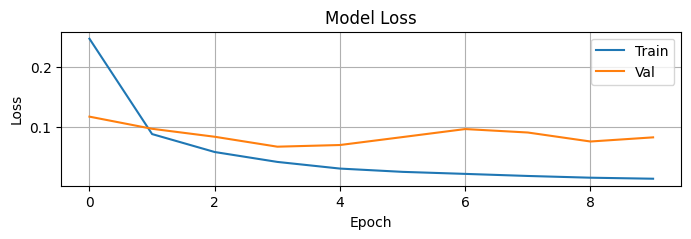


Model with dropout:



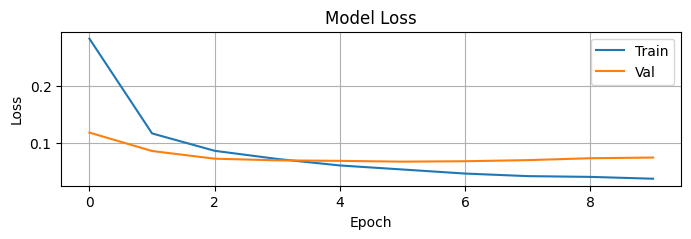

In [82]:
print("Default model:\n")
plot_history(history)
print("\nModel with dropout:\n")
plot_history(history_dropout)

Notice how the validation loss stays closer to the training loss in the model with dropout compared to the original model.

## Normalization

### Batch Normalization

Batch Normalization normalizes the features by centering them around zero and rescaling them to have variance 1, which leads to faster and more stable training. To do so, batch normalization uses the statistics of the batch. Specifically, a batch normalization layer computes the mean and the standard deviation per channel, i.e. given a feature map of dimensionality $B\times H\times W\times C$ ($B$ is batch size, $H,W$ spatial dimensions and $C$ number of feature channels) the layer computes the mean $\mu$ and standard deviation $\sigma$ of the channels, where $\mu$ and $\sigma$ have dimensionality $1\times 1\times 1\times C$. Then, the mean $\mu$ and the standard deviation $\sigma$ of the batch are expanded again to $B\times H\times W\times C$ and used to standardize the input features to follow a distribution with mean 0 and variance 1. The layer output is then $y = \gamma\frac{x-\mu}{\sigma} + \beta$, where $\gamma$ and $\beta$ are learnable parameters that give the network more capacity to express different distributions.

The layer is defined in PyTorch by using:
```python
nn.BatchNorm2d(num_features=C) # C is number of channels

# NOTE: PyTorch expects channels-first format: (batch, channels, height, width).
# If your data is (batch, height, width, channels), you must permute it first:
# x = x.permute(0, 3, 1, 2)


Now we will generate a batch of 512x1 (a batch of 512 vectors of only 1 channel) using `np.random.random`, which is a uniform distribution under the $[0, 1)$ interval, resulting in mean 0.5 and variance 1/12. We will see how the batch normalization layer will scale the distribution to have mean 0 and variance 1.



In [33]:
x = np.random.random((512, 10, 10, 1)).astype(np.float32)
x_torch = torch.tensor(x)

# Permute to (batch, channels, height, width)
x_torch = x_torch.permute(0, 3, 1, 2)  # (512, 1, 10, 10)

# Create BatchNorm2d for 1 channel and apply
batch_norm = nn.BatchNorm2d(num_features=1)
batch_norm.train()
y = batch_norm(x_torch)

# Un-permute for printing
y = y.permute(0, 2, 3, 1)

print("Input:")
print(x[:10, 0, 0, 0])

print("Output:")
print(y[:10, 0, 0, 0].detach().numpy())

Input:
[0.2575163  0.21911064 0.04601935 0.8335426  0.20590955 0.07186326
 0.82316256 0.8707813  0.84505713 0.95700425]
Output:
[-0.84602153 -0.9790541  -1.5786213   1.1492634  -1.024781   -1.489101
  1.1133082   1.2782537   1.1891483   1.5769194 ]


In [34]:
# Input mean should be ~0.5 and var ~1/12=0.0833
print(f"Input mean: {x.mean():.5f}, var: {x.var():.5f}")

# Output mean should be ~0 and var ~1
print(f"Output mean: {y.mean().item():.5f}, var: {y.var().item():.5f}")

Input mean: 0.50176, var: 0.08333
Output mean: -0.00000, var: 0.99990


It is important to note that batch normalization changes behaviour in evaluation mode. During training, the layer tracks and updates the moving average of $\mu$ and $\sigma$ given all possible training batches. $\mu$ and $\sigma$ are then used to normalize the testing data without using the statistics from the testing batch.

Generally, using Batch Normalization results in faster training and easier convergence. It is quite standard to place Batch Normalization layers just before the activation function, but we can also achieve good performance by placing it after the activation function. So you can see blocks of Conv+BN+Activation or Conv+Activation+BN in different networks.

You can add your Batch Normalization layer as any other layer in your sequential model:

In [35]:
model = nn.Sequential(
    nn.BatchNorm2d(num_features=512) # Example with 512 channels
)

### Instance Normalization

Instance Normalization normalizes each sample independently by centering its features around zero and rescaling them to have variance 1. Unlike batch normalization, which uses statistics aggregated across the whole mini-batch, instance normalization computes the mean and standard deviation separately for each sample and each channel. This makes it especially useful in tasks like style transfer, where preserving per-instance contrast and feature statistics is important.

Given a feature map of shape $B \times C \times H \times W$ ($B$ is batch size, $C$ is the number of channels), the layer computes the mean and standard deviation across the spatial dimensions for each channel within each sample. The input is then standardized using these statistics so that every channel in each sample has approximately zero mean and unit variance.

After normalization, learnable parameters $\gamma$ (scale) and $\beta$ (shift) are applied to each channel, allowing the network to reintroduce or adapt the normalized activations to any desired distribution.

In PyTorch, instance normalization can be defined with:

```python
nn.InstanceNorm2d(num_features=C) # C is number of channels


To demonstrate the effect of instance normalization, we will generate a batch of $2048 \times 1$ (a batch of 2048 images of size $32 \times 32$ with only 1 channel) using `np.random.random`, which samples uniformly in the interval $[0, 1)$. This produces inputs with a mean close to 0.5 and variance around $1/12$.

We will see how the instance normalization layer transforms each sample independently to have mean 0 and variance 1.



In [36]:
x = np.random.random((2048, 32, 32, 1)).astype(np.float32)
x_torch = torch.tensor(x).permute(0, 3, 1, 2)

# Create InstanceNorm2d for 1 channel and apply
instance_norm = nn.InstanceNorm2d(num_features=1, affine=False)

"""
'affine=false' means no learnable scale (gamma) and shift (beta)
parameters are applied after normalization
"""

instance_norm.train()
y = instance_norm(x_torch)

y = y.permute(0, 2, 3, 1)
x_torch = x_torch.permute(0, 2, 3, 1)

print("Input:")
print(x_torch[:10, 0, 0, 0].detach().numpy())

print("Output:")
print(y[:10, 0, 0, 0].detach().numpy())

Input:
[0.44639173 0.22535954 0.45392945 0.9570975  0.05030907 0.01078531
 0.3515622  0.12594153 0.29395252 0.09942824]
Output:
[-0.14739819 -0.9329934  -0.1931628   1.6038225  -1.5515156  -1.6381708
 -0.5437652  -1.312592   -0.73737866 -1.3786151 ]


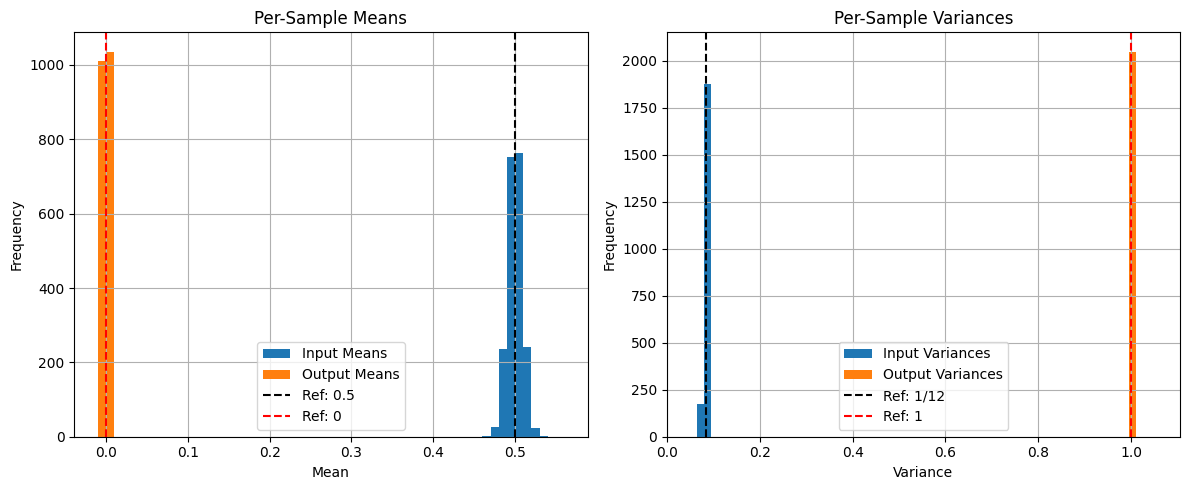

In [37]:
# Compute per-sample mean and var before and after
input_means = x_torch.mean(dim=(1,2))[:,0].detach().numpy()
input_vars = x_torch.var(dim=(1,2), unbiased=False)[:,0].detach().numpy()

output_means = y.mean(dim=(1,2))[:,0].detach().numpy()
output_vars = y.var(dim=(1,2), unbiased=False)[:,0].detach().numpy()

bin_edges_means = np.arange(-0.01, 0.55 + 0.01, 0.01)
bin_edges_stds = np.arange(0.05, 1.05 + 0.015, 0.015)
plt.figure(figsize=(12,5))

# Means
plt.subplot(1,2,1)
plt.hist(input_means, bins=bin_edges_means, label="Input Means")
plt.hist(output_means, bins=bin_edges_means, label="Output Means")
plt.axvline(0.5, color='black', linestyle='--', label='Ref: 0.5')
plt.axvline(0, color='red', linestyle='--', label='Ref: 0')
plt.title("Per-Sample Means")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Variances
plt.subplot(1,2,2)
plt.hist(input_vars, bins=bin_edges_stds, label="Input Variances")
plt.hist(output_vars, bins=bin_edges_stds, label="Output Variances")
plt.axvline(1/12, color='black', linestyle='--', label='Ref: 1/12')
plt.axvline(1, color='red', linestyle='--', label='Ref: 1')
plt.title("Per-Sample Variances")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

By the histograms above, we can see that the instance normalization layer has produced samples with per-sample means and variances tightly clustered around 0 and 1, as expected.

### Normalization Example

In [38]:
# Data loader function
def get_mnist_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_mnist_loaders()

In [39]:
def build_model(norm_type=None):
    layers = []
    layers.append(nn.Linear(784, 100))
    if norm_type == "batch":
        layers.append(nn.BatchNorm1d(100))
    elif norm_type == "instance":
        layers.append(nn.LayerNorm(100))
    layers.append(nn.Sigmoid())

    layers.append(nn.Linear(100, 100))
    if norm_type == "batch":
        layers.append(nn.BatchNorm1d(100))
    elif norm_type == "instance":
        layers.append(nn.LayerNorm(100))
    layers.append(nn.Sigmoid())

    layers.append(nn.Linear(100, 100))
    layers.append(nn.Sigmoid())

    layers.append(nn.Linear(100, 10))
    return nn.Sequential(*layers)


In [40]:
histories = {}

for norm in ["no", "batch", "instance"]:
    print(f"\nTraining model with {norm} normalization:")
    model = build_model(norm_type=(None if norm=="no" else norm))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    histories[norm] = train(
        model, train_loader, criterion, optimizer, num_epochs=10, val_loader=test_loader
    )


Training model with no normalization:
Epoch 1/10 - Train loss: 1.0704, acc: 0.6728 - Val loss: 0.3951, acc: 0.8955
Epoch 2/10 - Train loss: 0.3075, acc: 0.9154 - Val loss: 0.2337, acc: 0.9341
Epoch 3/10 - Train loss: 0.2045, acc: 0.9428 - Val loss: 0.1797, acc: 0.9469
Epoch 4/10 - Train loss: 0.1564, acc: 0.9557 - Val loss: 0.1496, acc: 0.9569
Epoch 5/10 - Train loss: 0.1268, acc: 0.9637 - Val loss: 0.1331, acc: 0.9620
Epoch 6/10 - Train loss: 0.1062, acc: 0.9696 - Val loss: 0.1167, acc: 0.9660
Epoch 7/10 - Train loss: 0.0885, acc: 0.9748 - Val loss: 0.1123, acc: 0.9660
Epoch 8/10 - Train loss: 0.0763, acc: 0.9778 - Val loss: 0.1082, acc: 0.9691
Epoch 9/10 - Train loss: 0.0663, acc: 0.9811 - Val loss: 0.1019, acc: 0.9697
Epoch 10/10 - Train loss: 0.0577, acc: 0.9835 - Val loss: 0.0997, acc: 0.9709

Training model with batch normalization:
Epoch 1/10 - Train loss: 0.8965, acc: 0.8117 - Val loss: 0.3171, acc: 0.9183
Epoch 2/10 - Train loss: 0.2402, acc: 0.9345 - Val loss: 0.1809, acc: 0

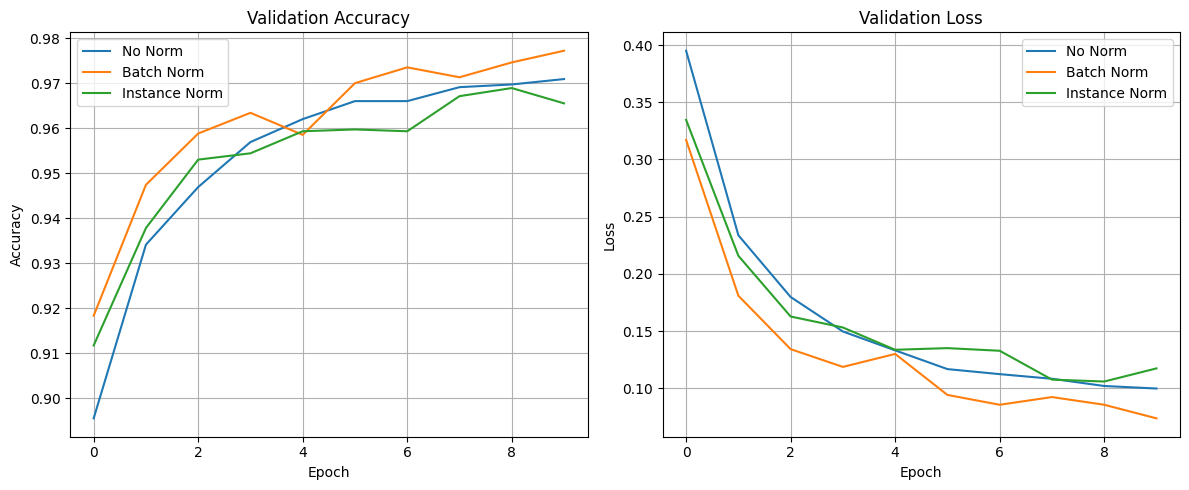

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Accuracy
for norm, history in histories.items():
    axes[0].plot(history["val_accuracy"], label=f"{norm.capitalize()} Norm")
axes[0].set_title("Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Loss
for norm, history in histories.items():
    axes[1].plot(history["val_loss"], label=f"{norm.capitalize()} Norm")
axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In this example, we see that Batch Normalization speeds up convergence and achieves the best validation accuracy overall. Instance Normalization also accelerates training compared to no normalization but reaches a similar final performance after 10 epochs. Batch Normalization remains a common choice in feedforward networks, while Instance Normalization is often preferred in tasks like style transfer where per-sample normalization can be beneficial (see [*Instance Normalization: The Missing Ingredient for Fast Stylization*](https://arxiv.org/pdf/1607.08022) for details).


## HyperParameters Tuning

### Creating a Validation Set

When training our model, we need to decide the value of several hyperparameters, what regularization techniques we employ, or the loss used to train the model, among others. To decide these values we should not use as guidance the performance in the test set, as it may lead to overfitting to that set, and in turn to an erroneous estimate of the performance of the model in non-seen data. Hence, we use what is called a validation set, which we use to tweak the hyperparameters.

In PyTorch, there is no built-in *validation split* parameter in `DataLoader`. Instead, you usually manually split your training set into a training and validation set using tools like `torch.utils.data.random_split`. For example:   
```python
from torch.utils.data import random_split, DataLoader

# Suppose 'dataset' contains all training data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_subset, val_subset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
```
This splits 80% of the data for training and 20% for validation.

In these tutorials, we often reuse the official test sets of standard datasets (e.g., MNIST test set) as validation data, to ensure everyone works with the same split and can easily compare results. However, in a real project, you should keep the test set completely untouched and reserved for final evaluation only, after all hyperparameter tuning is complete.

### Early Stopping

We now know how to define a validation set and how to use it during the training process. An important step now is how to retrieve the model with the highest validation performance during training. Usually, you keep the model with the highest validation accuracy as your final model, and then, ideally, you would test this final model using an independent test set.
However, validation accuracy fluctuates between epochs, and may actually decrease after a few epochs due to overfitting. Hence, we would like to save the model with the best validation performance.

We already mentioned how to save the best-performing model in the introductory PyTorch tutorial, but let’s explain it again now that we know how to define a validation split. By default, PyTorch training loops keep updating the model for all $N$ epochs. To instead retrieve the model with the best validation performance, we can implement early stopping. Early stopping monitors a metric (for example, validation accuracy) and stops training after a specified number of epochs (patience) without improvement. Finally, we can restore the weights of the best model seen during training to avoid overfitting to later epochs.

For example:

In [42]:
# Get data and model
model, train_loader, test_loader = get_data_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
patience = 4  # Stop after 4 epochs without improvement

best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0
epochs_no_improve = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    val_loss = val_running_loss / len(test_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"Train loss: {epoch_loss:.4f}, "
        f"Val loss: {val_loss:.4f}, "
        f"Val acc: {val_acc:.4f}"
    )

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/20 - Train loss: 0.2486, Val loss: 0.1106, Val acc: 0.9651
Epoch 2/20 - Train loss: 0.0896, Val loss: 0.0782, Val acc: 0.9771
Epoch 3/20 - Train loss: 0.0588, Val loss: 0.0714, Val acc: 0.9773
Epoch 4/20 - Train loss: 0.0418, Val loss: 0.0761, Val acc: 0.9775
Epoch 5/20 - Train loss: 0.0322, Val loss: 0.0708, Val acc: 0.9790
Epoch 6/20 - Train loss: 0.0252, Val loss: 0.0748, Val acc: 0.9786
Epoch 7/20 - Train loss: 0.0189, Val loss: 0.0719, Val acc: 0.9817
Epoch 8/20 - Train loss: 0.0181, Val loss: 0.0890, Val acc: 0.9773
Epoch 9/20 - Train loss: 0.0182, Val loss: 0.0778, Val acc: 0.9809
Epoch 10/20 - Train loss: 0.0160, Val loss: 0.0709, Val acc: 0.9821
Epoch 11/20 - Train loss: 0.0121, Val loss: 0.0943, Val acc: 0.9808
Epoch 12/20 - Train loss: 0.0109, Val loss: 0.0893, Val acc: 0.9825
Epoch 13/20 - Train loss: 0.0138, Val loss: 0.0900, Val acc: 0.9791
Epoch 14/20 - Train loss: 0.0122, Val loss: 0.0877, Val acc: 0.9806
Epoch 15/20 - Train loss: 0.0090, Val loss: 0.1003, Val a

<All keys matched successfully>

We see how the training process stopped after failing to improve `val_acc` during the number of epochs set by `patience`. We now check that the performance of the saved model is the same as the obtained in the best epoch in terms of validation accuracy.

In [43]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [44]:
val_loss, val_acc = evaluate_model(model, test_loader, criterion)
print(f"Test loss: {val_loss:.4f}, Test accuracy: {val_acc:.4f}")

Test loss: 0.0893, Test accuracy: 0.9825


### Learning Rate

One of the most important parameters to tweak is the learning rate, which controls the update step performed during the backpropagation. In PyTorch, this can be adjusted dynamically during training using learning rate schedulers. Two common approaches are:

- **Step Learning Rate Scheduler**, which reduces the learning rate by a factor every fixed number of epochs.
- **Reduce on Plateau Scheduler**, which monitors a validation metric (like loss) and reduces the learning rate when the metric stops improving.

We will demonstrate both schedulers in the examples below.

For details, see the [PyTorch LR scheduler documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In this example, we define a *step* learning rate scheduler (or `StepLR`) that decreases the learning rate by a factor of 0.1 every 3 epochs. This allows the optimizer to take larger steps in the beginning and finer adjustments later in training.


In [45]:
model, train_loader, test_loader = get_data_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define StepLR scheduler: decay LR by 0.1 every 3 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

step_lr_history = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_running_loss / len(test_loader.dataset)

    # Step the scheduler
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    step_lr_history.append(current_lr)

    print(
        f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - LR: {current_lr:.6f}"
    )

print(f"\nInitial Learning Rate: {step_lr_history[0]:.6f}")
print(f"Final Learning Rate: {step_lr_history[-1]:.10f}")


Epoch 1/10 - Train Loss: 0.2470 - Val Loss: 0.1111 - LR: 0.001000
Epoch 2/10 - Train Loss: 0.0894 - Val Loss: 0.0810 - LR: 0.001000
Epoch 3/10 - Train Loss: 0.0593 - Val Loss: 0.0733 - LR: 0.000100
Epoch 4/10 - Train Loss: 0.0241 - Val Loss: 0.0561 - LR: 0.000100
Epoch 5/10 - Train Loss: 0.0175 - Val Loss: 0.0553 - LR: 0.000100
Epoch 6/10 - Train Loss: 0.0141 - Val Loss: 0.0558 - LR: 0.000010
Epoch 7/10 - Train Loss: 0.0111 - Val Loss: 0.0549 - LR: 0.000010
Epoch 8/10 - Train Loss: 0.0105 - Val Loss: 0.0547 - LR: 0.000010
Epoch 9/10 - Train Loss: 0.0102 - Val Loss: 0.0549 - LR: 0.000001
Epoch 10/10 - Train Loss: 0.0098 - Val Loss: 0.0548 - LR: 0.000001

Initial Learning Rate: 0.001000
Final Learning Rate: 0.0000010000


Another learning rate scheduler is `ReduceLROnPlateau`, which reduces the learning rate whenever a given metric has stopped improving. There are 5 important arguments:

 * `monitor`: we specify the metric we want to track
 * `patience`: number of epochs without improvement before reducing lr
 * `factor`: the new learning rate will be `new_lr = lr * factor`
 * `min_lr`: sets the minimum lr
 * `min_delta`: margin to define when the metric has stopped improving


In [46]:
model, train_loader, test_loader = get_data_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Reduce LR on Plateau: monitor validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=1,
    threshold=0.01,
    min_lr=1e-5
)

plateau_lr_history = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    plateau_lr_history.append(current_lr)

    print(
        f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - LR: {current_lr:.6f}"
    )

print(f"\nInitial Learning Rate: {plateau_lr_history[0]:.6f}")
print(f"Final Learning Rate: {plateau_lr_history[-1]:.10f}")


Epoch 1/10 - Train Loss: 0.2503 - Val Loss: 0.1200 - LR: 0.001000
Epoch 2/10 - Train Loss: 0.0888 - Val Loss: 0.0784 - LR: 0.001000
Epoch 3/10 - Train Loss: 0.0580 - Val Loss: 0.0780 - LR: 0.001000
Epoch 4/10 - Train Loss: 0.0417 - Val Loss: 0.0736 - LR: 0.001000
Epoch 5/10 - Train Loss: 0.0327 - Val Loss: 0.0746 - LR: 0.001000
Epoch 6/10 - Train Loss: 0.0244 - Val Loss: 0.0692 - LR: 0.001000
Epoch 7/10 - Train Loss: 0.0216 - Val Loss: 0.0793 - LR: 0.001000
Epoch 8/10 - Train Loss: 0.0182 - Val Loss: 0.0849 - LR: 0.000200
Epoch 9/10 - Train Loss: 0.0046 - Val Loss: 0.0624 - LR: 0.000200
Epoch 10/10 - Train Loss: 0.0016 - Val Loss: 0.0637 - LR: 0.000200

Initial Learning Rate: 0.001000
Final Learning Rate: 0.0002000000


Again, we check how the learning rate has changed. You can check that the learning has indeed decreased when the `val_loss` has not improved by more than 0.01 until it reached the `min_lr` value.

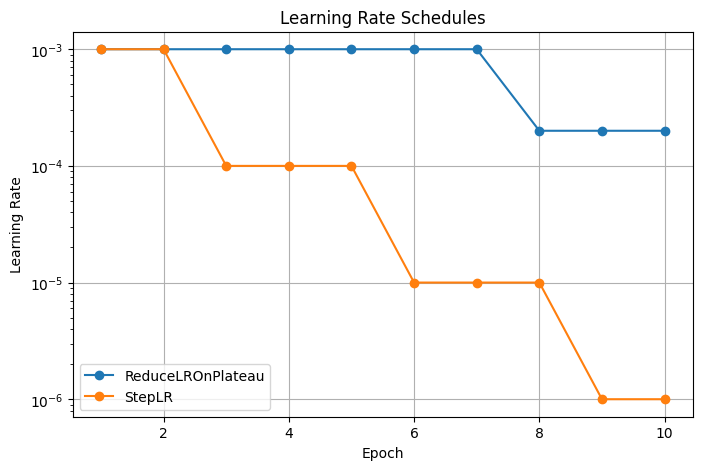

In [47]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(plateau_lr_history)+1), plateau_lr_history, marker='o', label="ReduceLROnPlateau")
plt.plot(range(1, len(step_lr_history)+1), step_lr_history, marker='o', label="StepLR")
plt.title("Learning Rate Schedules")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## Data augmentation
Deep learning models are data-hungry, tend to overfit with small training sets and its performance benefit from large training sets. A way to synthetically create more data is using data augmentation. Data augmentation aims to modify the training examples by applying transformations to the input data. Now, we will show some examples of data augmentation for images.

### Images
Data augmentation techniques such as rotation, scaling or cropping are usually applied in deep learning pipelines for vision applications. The idea is to take as input an image, apply a transformation to it, and then use it for training.

In PyTorch, data augmentation is typically performed using torchvision.transforms, which provides a wide range of transformations you can compose and apply to your datasets. These transformations can be combined in a Compose object and are applied on the fly during data loading, often leveraging multiple CPU workers to keep the GPU fed efficiently. The available transformations are listed [here](https://pytorch.org/vision/stable/transforms.html).




We first define a function `plot_data_augmentation` that we will use to show some augmented examples.



In [48]:
def plot_data_augmentation(augmentation=None):
    # Basic transform: convert to tensor only
    base_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # If augmentation is provided, chain it after ToTensor
    if augmentation is not None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            augmentation
        ])
    else:
        transform = base_transform

    # Load MNIST dataset with the transform
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

    # Fetch a single batch
    images, labels = next(iter(loader))
    images_np = images.squeeze().numpy()

    plt.figure(figsize=(15,3))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(images_np[i], cmap="gray")
        plt.axis("off")
    plt.show()

We will now visualize some of the transformations available in this preprocessing module. First, we plot some images without any transformations applied for comparison.

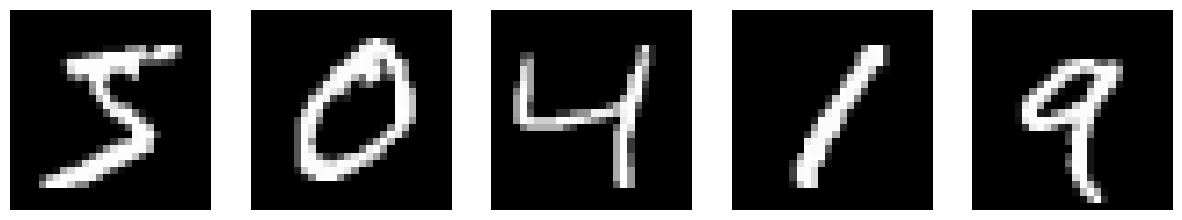

In [49]:
plot_data_augmentation()

### Rotation
A standard transformation is to rotate the image. In PyTorch, you can use [`transforms.RandomRotation`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation), which rotates the image by a random angle within a specified range.

For example, `transforms.RandomRotation(degrees=45)` rotates the image randomly between -45 and +45 degrees.

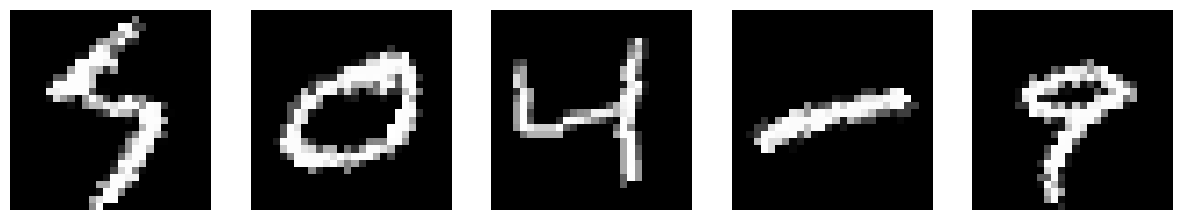

In [50]:
plot_data_augmentation(transforms.RandomRotation(degrees=45))

### Shift

We can define a maximum range of both horizontal and vertical shifts using [`transforms.RandomAffine`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomAffine).

In PyTorch, shifting is handled by the `translate argument`, which specifies the maximum fraction for horizontal and vertical translation.

For example, `transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))` randomly shifts the image horizontally and vertically by up to 20% of its size.

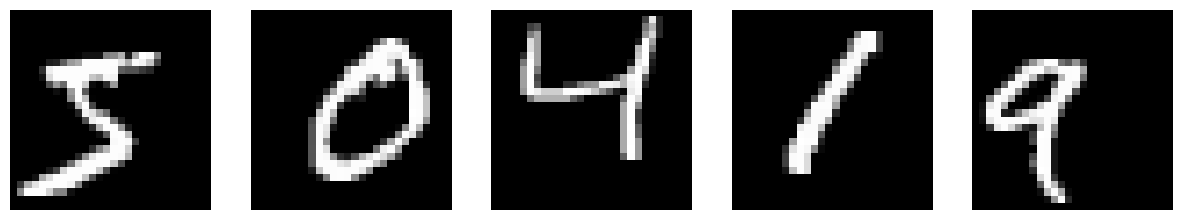

In [51]:
plot_data_augmentation(transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)))

### Zooming
Zooming into the image can also be achieved using [`transforms.RandomAffine`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomAffine).

Instead of a separate zoom transformation, `RandomAffine` uses the `scale` argument to specify the range of scaling factors applied randomly.

For example, `transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))` will randomly zoom in or out by scaling the image between 80% and 120% of its original size.

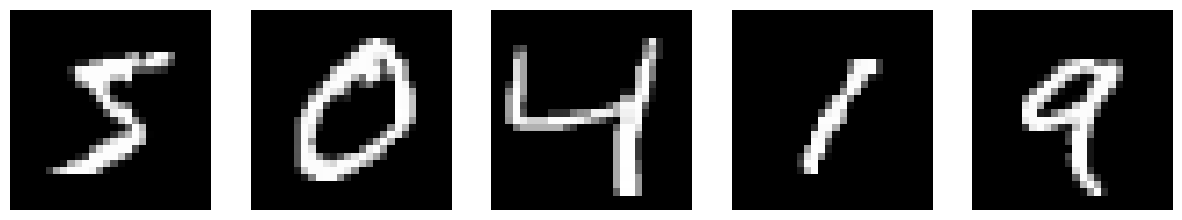

In [52]:
plot_data_augmentation(transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)))

### Flip

We can apply random horizontal and/or vertical flips to augment the dataset. In PyTorch, the most common option is `transforms.RandomHorizontalFlip`, which flips images horizontally with a specified probability (default is 0.5). Vertical flips can be applied using `transforms.RandomVerticalFlip`. To randomly apply both flips independently, we can combine them in a `Compose` transform.

Below is an example where each flip has a 50% chance of being applied:




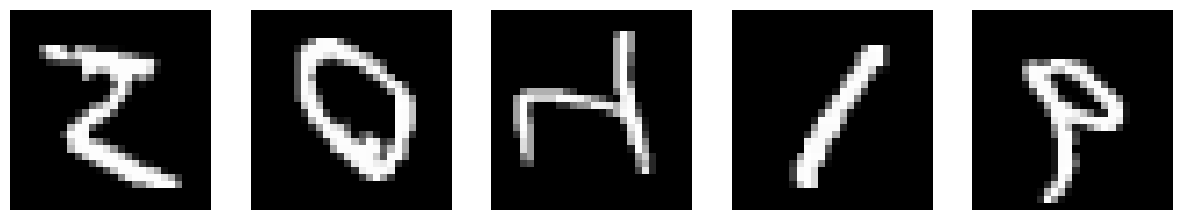

In [53]:
flip_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

plot_data_augmentation(flip_transform)

### Data Normalization
Data normalization is usually applied in deep learning pipelines. A typical data normalization applied is data standardization, where we transform the input data to have `mean=0` and `std=1`. When you have multiple features coming from different distributions and different scales, normalization makes all of the features have a similar distribution, which avoids biasing the model towards using the features with larger values.

In images, the range of values is already in the same scale of [0-255], but normalizing the range of values to [0-1] can help us avoid starting training in the saturation regions of some activations, such as a sigmoid, where values of large magnitude will fall into the flat region of the activation. Data centering (mean=0) can also useful in some settings because the weight initializers used (e.g. Xavier) are derived following a ``mean=0`` assumption about the data distribution, but probably a model trained with [0-1] will usually converge too.

To perform normalization in PyTorch, you typically compute the mean and standard deviation of the training set manually, and then define a `transforms.Normalize()` transformation with these values. Once defined, this normalization transform can be applied consistently to both the training and test data, ensuring the inputs are standardized with `mean=0` and `std=1`.

In [54]:
# Load MNIST training data
train_dataset_raw = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
train_loader_raw = torch.utils.data.DataLoader(train_dataset_raw, batch_size=len(train_dataset_raw))
train_data_tensor, _ = next(iter(train_loader_raw))
train_data_numpy = train_data_tensor.numpy()

# Compute mean and std
mean = train_data_numpy.mean()
std = train_data_numpy.std()

print(f"Train set original mean/std: {mean:.5f} / {std:.5f}")

# Define and apply normalization transform
normalize_transform = transforms.Normalize(mean=[mean], std=[std])
normalized_data = []

for img, _ in train_dataset_raw:
    img_norm = normalize_transform(img)
    normalized_data.append(img_norm)

normalized_tensor = torch.stack(normalized_data)
normalized_numpy = normalized_tensor.numpy()

print(f"Train set normalized mean/std: {normalized_numpy.mean():.5f} / {normalized_numpy.std():.5f}")


Train set original mean/std: 0.13066 / 0.30811
Train set normalized mean/std: -0.00000 / 1.00000


When using any kind of data normalization, it is important to note that we need to apply the same transformation to the test data for our model to work properly. In the given example we can use the statistics computed from the training data to standardize the test data:

In [55]:
# Load MNIST test data
test_dataset_raw = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
test_loader_raw = torch.utils.data.DataLoader(train_dataset_raw, batch_size=len(test_dataset_raw))
test_data_tensor, _ = next(iter(test_loader_raw))
test_data_numpy = test_data_tensor.numpy()

print(f"Test set original mean/std: {test_data_numpy.mean():.5f} / {test_data_numpy.std():.5f}")

normalized_data = []
for img, _ in test_dataset_raw:
    img_norm = normalize_transform(img)
    normalized_data.append(img_norm)

normalized_tensor = torch.stack(normalized_data)
normalized_numpy = normalized_tensor.numpy()

print(f"Train set normalized mean/std: {normalized_numpy.mean():.5f} / {normalized_numpy.std():.5f}")


Test set original mean/std: 0.13113 / 0.30870
Train set normalized mean/std: 0.00602 / 1.00770


### Combining transformations
We have seen examples of individual data augmentation transformations. Next, we will show how to combine multiple transformations together and integrate them into a full training pipeline. In PyTorch, this is done by composing all the transformations into a single `transforms.Compose` sequence, which is applied to each training sample before it is passed to the model.

Epoch 1/10 - Train loss: 0.5938, acc: 0.8039 - Val loss: 0.2331, acc: 0.9266
Epoch 2/10 - Train loss: 0.3172, acc: 0.8964 - Val loss: 0.1833, acc: 0.9419
Epoch 3/10 - Train loss: 0.2647, acc: 0.9142 - Val loss: 0.1940, acc: 0.9344
Epoch 4/10 - Train loss: 0.2336, acc: 0.9250 - Val loss: 0.1465, acc: 0.9511
Epoch 5/10 - Train loss: 0.2082, acc: 0.9308 - Val loss: 0.1353, acc: 0.9547
Epoch 6/10 - Train loss: 0.1956, acc: 0.9363 - Val loss: 0.1192, acc: 0.9613
Epoch 7/10 - Train loss: 0.1902, acc: 0.9386 - Val loss: 0.1245, acc: 0.9612
Epoch 8/10 - Train loss: 0.1773, acc: 0.9433 - Val loss: 0.1010, acc: 0.9659
Epoch 9/10 - Train loss: 0.1686, acc: 0.9456 - Val loss: 0.0955, acc: 0.9680
Epoch 10/10 - Train loss: 0.1655, acc: 0.9456 - Val loss: 0.1028, acc: 0.9675


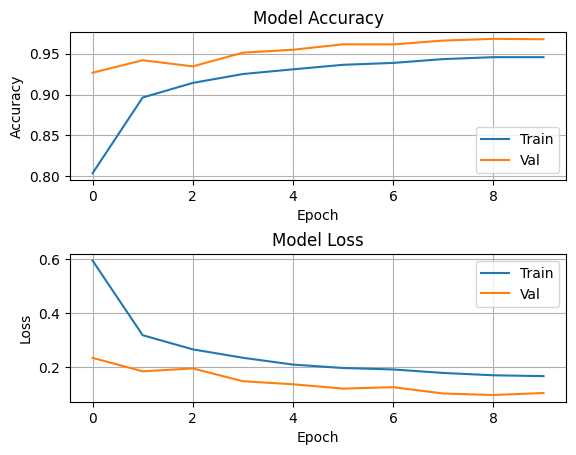

In [56]:
# Dataset statistics (calculated before)
mean = 0.13066
std = 0.30811

# Defining a composed transform with normalization and augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
    transforms.Lambda(lambda x: x.view(-1))
])

# For the test set, we only normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
    transforms.Lambda(lambda x: x.view(-1))
])

model, train_loader, test_loader = get_data_model(train_transform=train_transform, test_transform=test_transform)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
history = train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=test_loader)
plot_history(history, "accuracy")

With this setup, data augmentation is applied on-the-fly during training each time a batch is loaded. At evaluation time, only normalization is performed.

> **Note**: In PyTorch, augmentations are applied dynamically when sampling batches, rather than as part of a model layer. This design avoids storing augmented copies and ensures fresh randomized transformations at every epoch.

In these examples, we showed practical examples of data augmentation for images. However, other modalities, such as text or audio can also benefit from data augmentation.

Keep in mind that applying a data augmentation strategy that is too aggressive may actually harm the performance in the test set, e.g., applying extreme zooms not likely to be present in the dataset or strong contrast shifts.

# Coursework

### Task 1: Tuning a Classification Model
In a machine learning problem, and especially when using a deep learning approach, finding the right set of hyperparameters, the right data augmentation strategy, or a good regularization method can make the difference between a model that performs poorly and a model with great accuracy.

For this exercise, you will be training a CNN to perform classification in CIFAR-10 (we use the official test set, which is why the variables are called `x_test` and `y_test`, as our validation set) and will analyze the impact of some of the most important elements presented in this tutorial.

Use the CNN we give in the code below, along with the given optimizer and number of training epochs as the default setting. Only modify the given CNN architecture to add Dropout or Batch Normalization layers when explicitly stated. Use 40 epochs to plot all of your curves. However, you can train for more epochs to find your best validation performance if your network has not finished training in those 40 epochs.

**Report:**
*  First, train the given default model without any data augmentation. Then define two data augmentation strategies (one more aggressive than the other) and train the model with data augmentation. Clearly state the two augmentation strategies you apply (i.e., the specific transformations). Discuss the training and validation loss curves for the two data augmentation strategies along with the original run without data augmentation. Attach in the appendix those training and validation curves. Report in a table the best validation accuracy obtained for the three runs (no data augmentation, data augmentation 1, data augmentation 2).

*  Without using any data augmentation, analyze the effect of using Dropout in the model. Carry out the same analysis for Batch Normalization. Finally, combine both. Report in the same table as in the data augmentation task the best validation accuracy for each of the three settings (baseline + Dropout, baseline + Batch Normalization, baseline + Batch Normalization + Dropout). The performance will vary depending on where the Dropout layers and Batch Normalization layers are, so state clearly where you added the layers, and what rate you used for the Dropout layers. Discuss the results.

* Using the default model/hyperparameters and no data augmentation, report the best validation accuracy when using `zeros` for the kernel initialization. Report the performance in the same table as in the dropout/batch normalization/data augmentation tasks. Discuss the results that you obtained.

*  Using the default model and no data augmentation, change the optimizer to SGD and train it with learning rates of `3e-3`, `1e-3` and `3e-4`. Report in a figure the training and validation loss for the three learning rate values and discuss the figure.

In [57]:
# Loading CIFAR-10 train set to calculate mean and std for normalizations
x = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(x, batch_size=len(x), shuffle=False)
data_tensor, _ = next(iter(loader))

# Compute mean and std per channel
mean = data_tensor.mean(dim=[0,2,3])
std = data_tensor.std(dim=[0,2,3])

mean = mean.tolist()
std = std.tolist()

print("Per-channel mean:", mean)
print("Per-channel std:", std)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Per-channel mean: [0.491400808095932, 0.48215898871421814, 0.44653093814849854]
Per-channel std: [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]


In [58]:
# Default: No augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # You can later add augmentations like:
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), etc.
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Image shape:", np.array(train_dataset[0][0]).shape)
print("Total number of training samples:", len(train_dataset))
print("Total number of validation samples:", len(test_dataset))

Image shape: (3, 32, 32)
Total number of training samples: 50000
Total number of validation samples: 10000


In [59]:
class CNNModel(nn.Module):
    def __init__(self, use_dropout=False, use_batchnorm=False, dropout_rate=0.5, init_mode="xavier_uniform"):
        super(CNNModel, self).__init__()

        def conv_block(in_channels, out_channels, use_bn, init, use_dropout, dropout_rate):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            if init == "zeros":
                nn.init.constant_(conv.weight, 0.0)
                nn.init.constant_(conv.bias, 0.0)
            else:
                nn.init.xavier_uniform_(conv.weight)
                nn.init.constant_(conv.bias, 0.0)
            layers = [conv]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            if use_dropout:
                layers.append(nn.Dropout2d(dropout_rate))
            return nn.Sequential(*layers)


        # 4 conv blocks with ReLU and MaxPool2d(padding=1)
        self.features = nn.Sequential(
            conv_block(3, 32, use_batchnorm, init_mode, use_dropout, dropout_rate),
            nn.MaxPool2d(2,2, padding=1),

            conv_block(32, 64, use_batchnorm, init_mode, use_dropout, dropout_rate),
            nn.MaxPool2d(2,2, padding=1),

            conv_block(64, 128, use_batchnorm, init_mode, use_dropout, dropout_rate),
            nn.MaxPool2d(2,2, padding=1),

            conv_block(128, 256, use_batchnorm, init_mode, use_dropout, dropout_rate)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate if use_dropout else 0.0),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

In [60]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=40, device="cuda"):
    model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0
        correct_val = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == targets).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = correct_val / len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} "
            f"- Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}"
        )

    history = {
        "train_loss": train_losses,
        "train_acc": train_accuracies,
        "val_loss": val_losses,
        "val_acc": val_accuracies
    }
    return history

In [61]:
model = CNNModel(use_dropout=False, use_batchnorm=False, init_mode="xavier_uniform")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4) # Edit optimizer and learning rate here.

history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=40)

Epoch 1/40 - Train Loss: 1.7261 - Train Acc: 0.3617 - Val Loss: 1.4976 - Val Acc: 0.4467
Epoch 2/40 - Train Loss: 1.4170 - Train Acc: 0.4824 - Val Loss: 1.3238 - Val Acc: 0.5122
Epoch 3/40 - Train Loss: 1.2777 - Train Acc: 0.5400 - Val Loss: 1.1915 - Val Acc: 0.5699
Epoch 4/40 - Train Loss: 1.1703 - Train Acc: 0.5824 - Val Loss: 1.1461 - Val Acc: 0.5844
Epoch 5/40 - Train Loss: 1.0965 - Train Acc: 0.6119 - Val Loss: 1.0817 - Val Acc: 0.6159
Epoch 6/40 - Train Loss: 1.0270 - Train Acc: 0.6384 - Val Loss: 1.0200 - Val Acc: 0.6404
Epoch 7/40 - Train Loss: 0.9710 - Train Acc: 0.6581 - Val Loss: 0.9825 - Val Acc: 0.6521
Epoch 8/40 - Train Loss: 0.9291 - Train Acc: 0.6710 - Val Loss: 0.9304 - Val Acc: 0.6745
Epoch 9/40 - Train Loss: 0.8863 - Train Acc: 0.6899 - Val Loss: 0.9434 - Val Acc: 0.6675
Epoch 10/40 - Train Loss: 0.8503 - Train Acc: 0.7004 - Val Loss: 0.8941 - Val Acc: 0.6860
Epoch 11/40 - Train Loss: 0.8134 - Train Acc: 0.7145 - Val Loss: 0.8443 - Val Acc: 0.7078
Epoch 12/40 - Train